In [1]:
import numpy as np
import cv2
import math
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh
import os
import glob

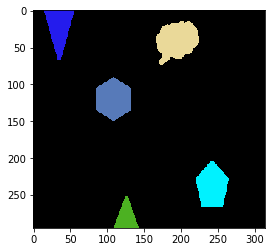

In [2]:
'''
Load and Show for overview reasons only
'''
im = cv2.imread('test_color.png')
plt.imshow(im)

In [3]:
'''
Returns the coords of contours within an image
'''
def get_contours(im):

    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, _ = cv2.findContours(thresh,cv2.CHAIN_APPROX_SIMPLE,cv2.RETR_LIST)

    return contours

In [4]:
'''
Makes rectangles out of points of interest found by get_contours()
'''
def get_boxes(contours):
    my_boxes = []


    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)

        coords = [x,y,w,h]

        my_boxes.append(coords)
    
    return my_boxes

In [5]:
'''
Makes found boxes by get_boxes() square
'''
def make_square(boxes):
    
    squares = []
    
     
    
    for box in boxes:
        x,y,w,h = box
        if h > w:
            diff = h-w
            x = math.floor(x - (diff/2))
            w = math.ceil(w + diff)
    
        if w > h:
            diff = w-h
            y = math.floor(y - (diff/2))
            h = math.ceil(h + diff)
            
        squares.append([x,y,w,h])
    return squares

In [6]:
'''
!!! Test only function !!!
Shows the found squares by drawing them on the image
'''

def draw_squares(im,squares):
    for square in squares:
        x,y,w,h = square
        im2 = cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
        plt.imshow(im2)
    plt.show()

In [7]:
'''
Combines functions above:
Input is an Image, returns squares around blobs
'''
def get_bounding_boxes(im):
    contours = get_contours(im)
    boxes = get_boxes(contours)
    squares = make_square(boxes)
    
    return squares

In [8]:
######################################################################

In [46]:
'''
Turns Squares around rois into actual images
'''
def get_found_imgs(im,squares):
    found_imgs = []
    for square in squares:
        new_im = im[square[1]:square[1]+square[3], square[0]:square[0]+square[2]]
#         print("square:",square)
        img = Image.fromarray(new_im, 'RGB')
        found_imgs.append(img)
    return found_imgs

In [10]:
'''
Scales all found images to one size
if size == 0: No scaling

''' 
def scale_imgs(imgs,size):
    scaled_imgs = []
    for im in imgs:
        if size == 0:
            new_im = im
        else:
            new_im = ImageOps.fit(im, size, Image.ANTIALIAS)
        scaled_imgs.append(new_im)
    return scaled_imgs

In [91]:
'''
MAIN FUNCTION!!!

Combines everything above. Takes binary image, original image and set size
Returns list of images found within original image.
'''

def get_roi_imgs(im_bin,im_ori,size):
    squares = get_bounding_boxes(im_bin)
    imgs_unscaled = get_found_imgs(im_ori,squares)
    imgs = scale_imgs(imgs_unscaled,size)
    
    return imgs_unscaled

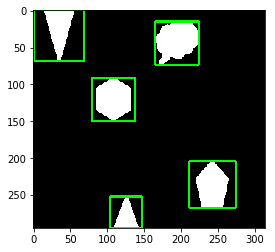

In [12]:
'''
Test Cell! 
Tests bounding boxes
'''

im = cv2.imread('test_black_white.png')
im_original = cv2.imread('test_color.png')
squares = get_bounding_boxes(im)

draw_squares(im,squares)

In [13]:
'''
Execution Cell!

Load Black and White image to work with
Load original image for actual image retrieval
Set size for universal scaling. 

'''
im = cv2.imread('test_black_white.png')
im_original = cv2.imread('test_color.png')


size = (60,60)
imgs = get_roi_imgs(im,im_original,size)


[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [ 76 177  34]
 [ 76 177  34]
 [ 76 177  34]
 [ 76 177  34]
 [ 76 177  34]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]]
[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0

In [79]:
'''
Saves found images to files in current directory.
'''
def imgs_to_files(imgs,nom,labels=None ):
    count = 0
    labeled_directory = "cnn_data"
    if not os.path.isdir('./' + labeled_directory):
        os.mkdir(labeled_directory)
    for im in imgs:
        name = labeled_directory + "/canditate_"+nom+ "_"+ str(count) + "is_robot_equals_" + str(labels[count]) + ".png"
        print(name)
        im.save(name)   
        count += 1
    
    return

In [15]:
print(imgs)
imgs_to_files(imgs)


[<PIL.Image.Image image mode=RGB size=60x60 at 0x7F4A3EE82C50>, <PIL.Image.Image image mode=RGB size=60x60 at 0x7F4A3EE82C18>, <PIL.Image.Image image mode=RGB size=60x60 at 0x7F4A3EE82CF8>, <PIL.Image.Image image mode=RGB size=60x60 at 0x7F4A3EE82D30>, <PIL.Image.Image image mode=RGB size=60x60 at 0x7F4A3EE2C780>]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
###############################################################################

In [ ]:
'''
In case of blobs:
y,x,sigma
All of the below!
'''

In [41]:
def make_blob_square(blobs):
    squares = []

    for blob in blobs:
        
        y_cen, x_cen, rad = blob
        
        x = x_cen - math.floor(rad)
        y = y_cen - math.floor(rad)
        
        w = rad*2
        h = rad*2
        
        xsiz= 479 - w
        ysiz = 639 - h
        
        if x < 0:
            x = 0
        elif x > xsiz:
            x = xsiz
        if y < 0:
            y = 0
        elif y > ysiz:
            y = ysiz
        square = [int(x),int(y),int(w),int(h)]
        squares.append(square)
    return squares

[[173, 13, 50, 50]]


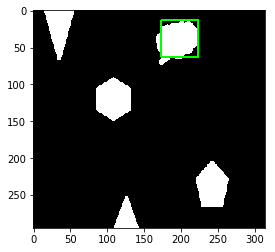

In [86]:
my_output = [[38.0, 198.0, 25.0]]

im = cv2.imread('test_black_white.png')

squares_blob = make_blob_square(my_output)
print(squares_blob)
draw_squares(im,squares_blob)

In [18]:
def get_roi_imgs_blobs(blobs,im_ori):
    squares = make_blob_square(blobs)
    imgs = get_found_imgs(im_ori,squares)
    
    return imgs, squares

In [37]:
imgs, squares = get_roi_imgs_blobs(my_output,im_original)
imgs[0].show()

square: [173, 13, 50, 50]


In [ ]:
##########################################################################################

In [20]:
'''Labeling'''

'Labeling'

In [21]:
labels = open('labels.txt')
l = labels.readlines()
print(l[6])
l = l[6:]

label::robot|16_02_2018__11_18_08_0001_upper.png|640|480|393|0|433|48|413.0|24.0|40|48



In [22]:
def make_label_file(labels):
    current_im = ''
    current_borders = []
    borders = []
    for label in labels:
        cells = label.split('|')
#         print(cells)
        these_borders = get_coords_from_label(cells)
        
        if cells[1] != current_im:
            current_im = cells[1]
            borders.append(current_borders)
            current_borders = [current_im]
        
        current_borders.append(these_borders)
    
    return borders[1:]

In [98]:
my_labels = make_label_file(l)
my_labels

[['16_02_2018__11_18_08_0001_upper.png',
  [393, 0, 40, 48],
  [269, 0, 41, 47],
  [546, 0, 37, 50]],
 ['16_02_2018__11_18_08_0002_upper.png',
  [562, 190, 36, 55],
  [463, 186, 35, 55],
  [297, 172, 52, 72],
  [37, 169, 48, 74],
  [162, 175, 47, 64]],
 ['16_02_2018__11_18_08_0003_upper.png',
  [443, 100, 47, 79],
  [321, 101, 48, 72]],
 ['16_02_2018__11_18_08_0006_upper.png',
  [316, 129, 49, 63],
  [445, 128, 52, 71],
  [612, 139, 28, 64]],
 ['16_02_2018__11_18_08_0008_upper.png', [0, 0, 0, 0]],
 ['16_02_2018__11_18_08_0009_upper.png', [438, 6, 75, 101], [228, 2, 73, 62]],
 ['16_02_2018__11_18_08_0010_upper.png', [517, 77, 62, 99]],
 ['16_02_2018__11_18_08_0012_upper.png',
  [268, 31, 58, 95],
  [571, 34, 69, 171]],
 ['16_02_2018__11_18_08_0015_upper.png', [376, 60, 85, 163]],
 ['16_02_2018__11_18_08_0016_upper.png', [0, 0, 0, 0]],
 ['16_02_2018__11_18_08_0017_upper.png', [0, 0, 0, 0]],
 ['16_02_2018__11_18_08_0018_upper.png', [0, 0, 0, 0]],
 ['16_02_2018__11_18_08_0019_upper.png',
 

In [96]:
def get_coords_from_label(cells):
    if cells[2] == 'not_in_image\n':
        return [0,0,0,0]
    else:
        cent_x = float(cells[8])
        cent_y = float(cells[9])
        w = int(cells[10])
        h = int(cells[11])

        x = cent_x - math.floor(w/2)
        y = cent_y - math.floor(h/2)

        square = [int(x),int(y),int(w),int(h)]
    
    return square

In [93]:
def get_labeled_imgs(labels,size):
    for label in labels:
        img_name = label[0]
        im = cv2.imread("imageset_131/" + img_name)
        bin_dir = 'bin_image2/'
        
        
        bin_img_name = bin_dir + img_name
        print("imgname:",img_name[-13:-10])
        bin_img = cv2.imread(bin_img_name,0)
#         print(bin_img_name)
#         plt.imshow(bin_img)
#         plt.show()
#         b,g,r = cv2.split(bin_img)
#         plt.imshow(b)
#         plt.show()
#         plt.imshow(g)
#         plt.show()
#         plt.imshow(r)
#         plt.show()
#         print(np.shape(), "hi")
#         print(bin_img)
        
        blobs = blob_doh(bin_img, max_sigma=50, min_sigma=30, threshold=.01, num_sigma=10)
#         print("blobs:",blobs)
        ''' dit is een lijst met blobs'''
        
        found_imgs, squares = get_roi_imgs_blobs(blobs,im)
#         print("squaresMain",squares)
        #Returns list of booleans for found regions
        in_robots = check_squares(squares, label[1:])
        
        imgs = scale_imgs(found_imgs, size)
        imgs_to_files(imgs,img_name[-13:-10],in_robots)
            
    return

In [77]:
def check_squares(squares,labels):
    # squares: found by blob detection
    # labels: of the robots
    bool_list = []
    for square in squares:
        is_in_robot = 0
        for label in labels:
#             print(square,label)
            if check_function_die_er_nog_niet_is(label, square):
                is_in_robot = 1
           
            
        bool_list.append(is_in_robot)
            
    return bool_list
        

In [103]:
def check_function_die_er_nog_niet_is(List1, List2):  # returns None if rectangles don't intersect
    print(List1,List2)
    thresh = 0.5
    [x1, y1, w1, h1] = List1  #van robot
    [x2,y2,w2,h2] = List2 #van Blob
    a = [x1 , y1+ h1, x1+w1, y1] # area robot
    b = [x2 , y2+ h2, x2+w2, y2] # area blob
    dx = min(a[2], b[2]) - max(a[0], b[0])  #'xmin ymin xmax ymax'
    dy =  min(a[1], b[1]) - max(a[3], b[3])

    
    if (dx>=0) and (dy>=0):
        opvblob = w2*h2
        intsecDivOpv = dx*dy/opvblob
        print("intersection:", dx*dy,"/oppervlakte",opvblob,"IOU",intsecDivOpv)
        if intsecDivOpv > thresh:
#             print("good candid")
            return True
#     print("bad candid")
    else:
        print("geen intersect")
    return False


In [105]:
get_labeled_imgs(my_labels,tuple((60,60)))

imgname: 001
imgname: 002
imgname: 003
imgname: 006
imgname: 008
imgname: 009
[438, 6, 75, 101] [419, 54, 60, 60]
intersection: 2173 /oppervlakte 3600 IOU 0.6036111111111111
[228, 2, 73, 62] [419, 54, 60, 60]
geen intersect
cnn_data/canditate_009_0is_robot_equals_1.png
imgname: 010
[517, 77, 62, 99] [137, 403, 60, 60]
geen intersect
[517, 77, 62, 99] [419, 113, 60, 60]
geen intersect
[517, 77, 62, 99] [379, 59, 100, 100]
geen intersect
[517, 77, 62, 99] [379, 0, 100, 100]
geen intersect
cnn_data/canditate_010_0is_robot_equals_0.png
cnn_data/canditate_010_1is_robot_equals_0.png
cnn_data/canditate_010_2is_robot_equals_0.png
cnn_data/canditate_010_3is_robot_equals_0.png
imgname: 012
[268, 31, 58, 95] [419, 234, 60, 60]
geen intersect
[571, 34, 69, 171] [419, 234, 60, 60]
geen intersect
[268, 31, 58, 95] [396, 110, 82, 82]
geen intersect
[571, 34, 69, 171] [396, 110, 82, 82]
geen intersect
[268, 31, 58, 95] [419, 54, 60, 60]
geen intersect
[571, 34, 69, 171] [419, 54, 60, 60]
geen intersec

[134, 56, 168, 69] [188, 20, 100, 100]
intersection: 6400 /oppervlakte 10000 IOU 0.64
[222, 0, 82, 125] [188, 20, 100, 100]
intersection: 6600 /oppervlakte 10000 IOU 0.66
[297, 0, 54, 68] [188, 20, 100, 100]
geen intersect
[170, 0, 47, 50] [188, 20, 100, 100]
intersection: 870 /oppervlakte 10000 IOU 0.087
[0, 0, 43, 55] [188, 20, 100, 100]
geen intersect
[134, 56, 168, 69] [297, 17, 60, 60]
intersection: 105 /oppervlakte 3600 IOU 0.029166666666666667
[222, 0, 82, 125] [297, 17, 60, 60]
intersection: 420 /oppervlakte 3600 IOU 0.11666666666666667
[297, 0, 54, 68] [297, 17, 60, 60]
intersection: 2754 /oppervlakte 3600 IOU 0.765
[170, 0, 47, 50] [297, 17, 60, 60]
geen intersect
[0, 0, 43, 55] [297, 17, 60, 60]
geen intersect
[134, 56, 168, 69] [0, 0, 100, 100]
geen intersect
[222, 0, 82, 125] [0, 0, 100, 100]
geen intersect
[297, 0, 54, 68] [0, 0, 100, 100]
geen intersect
[170, 0, 47, 50] [0, 0, 100, 100]
geen intersect
[0, 0, 43, 55] [0, 0, 100, 100]
intersection: 2365 /oppervlakte 10000 

[335, 94, 53, 117] [329, 151, 64, 64]
intersection: 3180 /oppervlakte 4096 IOU 0.7763671875
[0, 53, 43, 94] [329, 151, 64, 64]
geen intersect
cnn_data/canditate_044_0is_robot_equals_1.png
imgname: 058
[279, 97, 54, 118] [275, 145, 64, 64]
intersection: 3456 /oppervlakte 4096 IOU 0.84375
cnn_data/canditate_058_0is_robot_equals_1.png
imgname: 062
[464, 145, 18, 46] [414, 192, 64, 64]
geen intersect
[485, 142, 29, 48] [414, 192, 64, 64]
geen intersect
[430, 128, 53, 125] [414, 192, 64, 64]
intersection: 2928 /oppervlakte 4096 IOU 0.71484375
cnn_data/canditate_062_0is_robot_equals_1.png
imgname: 066
[517, 11, 123, 420] [275, 434, 60, 60]
geen intersect
[517, 11, 123, 420] [252, 394, 60, 60]
geen intersect
[517, 11, 123, 420] [379, 293, 100, 100]
geen intersect
[517, 11, 123, 420] [152, 159, 60, 60]
geen intersect
[517, 11, 123, 420] [107, 140, 60, 60]
geen intersect
[517, 11, 123, 420] [0, 0, 100, 100]
geen intersect
cnn_data/canditate_066_0is_robot_equals_0.png
cnn_data/canditate_066_1is_

[114, 0, 127, 206] [235, 125, 100, 100]
intersection: 486 /oppervlakte 10000 IOU 0.0486
[221, 0, 129, 210] [235, 125, 100, 100]
intersection: 8500 /oppervlakte 10000 IOU 0.85
[114, 0, 127, 206] [149, 124, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
[221, 0, 129, 210] [149, 124, 82, 82]
intersection: 820 /oppervlakte 6724 IOU 0.12195121951219512
[114, 0, 127, 206] [247, 60, 100, 100]
geen intersect
[221, 0, 129, 210] [247, 60, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[114, 0, 127, 206] [138, 39, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[221, 0, 129, 210] [138, 39, 100, 100]
intersection: 1700 /oppervlakte 10000 IOU 0.17
cnn_data/canditate_078_0is_robot_equals_1.png
cnn_data/canditate_078_1is_robot_equals_1.png
cnn_data/canditate_078_2is_robot_equals_1.png
cnn_data/canditate_078_3is_robot_equals_1.png
imgname: 079
[193, 0, 148, 227] [328, 174, 60, 60]
intersection: 689 /oppervlakte 3600 IOU 0.1913888888888889
[56, 0, 132, 159] [328, 174, 60, 60]
g

[174, 3, 341, 477] [314, 404, 100, 100]
intersection: 7600 /oppervlakte 10000 IOU 0.76
[174, 3, 341, 477] [200, 404, 100, 100]
intersection: 7600 /oppervlakte 10000 IOU 0.76
[174, 3, 341, 477] [154, 370, 86, 86]
intersection: 5676 /oppervlakte 7396 IOU 0.7674418604651163
[174, 3, 341, 477] [329, 328, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[174, 3, 341, 477] [419, 288, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[174, 3, 341, 477] [334, 221, 95, 95]
intersection: 9025 /oppervlakte 9025 IOU 1.0
[174, 3, 341, 477] [229, 158, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
cnn_data/canditate_088_0is_robot_equals_1.png
cnn_data/canditate_088_1is_robot_equals_1.png
cnn_data/canditate_088_2is_robot_equals_1.png
cnn_data/canditate_088_3is_robot_equals_1.png
cnn_data/canditate_088_4is_robot_equals_1.png
cnn_data/canditate_088_5is_robot_equals_1.png
cnn_data/canditate_088_6is_robot_equals_1.png
imgname: 089
[1, 153, 266, 324] [192, 434, 60, 60]
intersection: 2

[369, 6, 271, 474] [379, 379, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[90, 0, 142, 145] [379, 379, 100, 100]
geen intersect
[0, 0, 106, 273] [379, 379, 100, 100]
geen intersect
[369, 6, 271, 474] [379, 368, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[90, 0, 142, 145] [379, 368, 100, 100]
geen intersect
[0, 0, 106, 273] [379, 368, 100, 100]
geen intersect
[369, 6, 271, 474] [379, 238, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[90, 0, 142, 145] [379, 238, 100, 100]
geen intersect
[0, 0, 106, 273] [379, 238, 100, 100]
geen intersect
[369, 6, 271, 474] [379, 229, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[90, 0, 142, 145] [379, 229, 100, 100]
geen intersect
[0, 0, 106, 273] [379, 229, 100, 100]
geen intersect
[369, 6, 271, 474] [379, 159, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[90, 0, 142, 145] [379, 159, 100, 100]
geen intersect
[0, 0, 106, 273] [379, 159, 100, 100]
geen intersect
[369, 6, 271, 474] [396, 160, 

[250, 52, 204, 332] [306, 281, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[349, 206, 160, 99] [306, 281, 100, 100]
intersection: 1368 /oppervlakte 10000 IOU 0.1368
[250, 52, 204, 332] [383, 274, 95, 95]
intersection: 6745 /oppervlakte 9025 IOU 0.7473684210526316
[349, 206, 160, 99] [383, 274, 95, 95]
intersection: 2945 /oppervlakte 9025 IOU 0.3263157894736842
[250, 52, 204, 332] [247, 274, 68, 68]
intersection: 4420 /oppervlakte 4624 IOU 0.9558823529411765
[349, 206, 160, 99] [247, 274, 68, 68]
geen intersect
[250, 52, 204, 332] [242, 209, 82, 82]
intersection: 6068 /oppervlakte 6724 IOU 0.9024390243902439
[349, 206, 160, 99] [242, 209, 82, 82]
geen intersect
[250, 52, 204, 332] [372, 183, 100, 100]
intersection: 8200 /oppervlakte 10000 IOU 0.82
[349, 206, 160, 99] [372, 183, 100, 100]
intersection: 7700 /oppervlakte 10000 IOU 0.77
[250, 52, 204, 332] [210, 168, 73, 73]
intersection: 2409 /oppervlakte 5329 IOU 0.4520547945205479
[349, 206, 160, 99] [210, 168, 73, 73]
geen

[0, 52, 96, 352] [0, 294, 100, 100]
intersection: 9600 /oppervlakte 10000 IOU 0.96
[167, 102, 34, 56] [0, 294, 100, 100]
geen intersect
[531, 151, 86, 124] [0, 294, 100, 100]
geen intersect
[0, 52, 96, 352] [20, 258, 82, 82]
intersection: 6232 /oppervlakte 6724 IOU 0.926829268292683
[167, 102, 34, 56] [20, 258, 82, 82]
geen intersect
[531, 151, 86, 124] [20, 258, 82, 82]
geen intersect
[0, 52, 96, 352] [0, 194, 100, 100]
intersection: 9600 /oppervlakte 10000 IOU 0.96
[167, 102, 34, 56] [0, 194, 100, 100]
geen intersect
[531, 151, 86, 124] [0, 194, 100, 100]
geen intersect
[0, 52, 96, 352] [0, 102, 91, 91]
intersection: 8281 /oppervlakte 8281 IOU 1.0
[167, 102, 34, 56] [0, 102, 91, 91]
geen intersect
[531, 151, 86, 124] [0, 102, 91, 91]
geen intersect
cnn_data/canditate_141_0is_robot_equals_1.png
cnn_data/canditate_141_1is_robot_equals_1.png
cnn_data/canditate_141_2is_robot_equals_1.png
cnn_data/canditate_141_3is_robot_equals_1.png
imgname: 142
[457, 52, 181, 370] [379, 299, 100, 100]
i

[175, 52, 221, 340] [243, 281, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[175, 52, 221, 340] [183, 276, 68, 68]
intersection: 4624 /oppervlakte 4624 IOU 1.0
[175, 52, 221, 340] [175, 210, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
[175, 52, 221, 340] [306, 182, 100, 100]
intersection: 9000 /oppervlakte 10000 IOU 0.9
[175, 52, 221, 340] [145, 166, 73, 73]
intersection: 3139 /oppervlakte 5329 IOU 0.589041095890411
[175, 52, 221, 340] [254, 136, 95, 95]
intersection: 9025 /oppervlakte 9025 IOU 1.0
[175, 52, 221, 340] [193, 117, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
[175, 52, 221, 340] [33, 91, 100, 100]
geen intersect
cnn_data/canditate_152_0is_robot_equals_1.png
cnn_data/canditate_152_1is_robot_equals_1.png
cnn_data/canditate_152_2is_robot_equals_1.png
cnn_data/canditate_152_3is_robot_equals_1.png
cnn_data/canditate_152_4is_robot_equals_1.png
cnn_data/canditate_152_5is_robot_equals_1.png
cnn_data/canditate_152_6is_robot_equals_1.png
cnn_data/candit

[445, 61, 195, 354] [379, 304, 100, 100]
intersection: 3400 /oppervlakte 10000 IOU 0.34
[445, 61, 195, 354] [410, 282, 68, 68]
intersection: 2244 /oppervlakte 4624 IOU 0.4852941176470588
[445, 61, 195, 354] [396, 229, 82, 82]
intersection: 2706 /oppervlakte 6724 IOU 0.4024390243902439
[445, 61, 195, 354] [379, 212, 100, 100]
intersection: 3400 /oppervlakte 10000 IOU 0.34
[445, 61, 195, 354] [390, 176, 86, 86]
intersection: 2666 /oppervlakte 7396 IOU 0.36046511627906974
[445, 61, 195, 354] [383, 143, 95, 95]
intersection: 3135 /oppervlakte 9025 IOU 0.3473684210526316
[445, 61, 195, 354] [296, 103, 100, 100]
geen intersect
[445, 61, 195, 354] [142, 120, 64, 64]
geen intersect
[445, 61, 195, 354] [396, 103, 82, 82]
intersection: 2706 /oppervlakte 6724 IOU 0.4024390243902439
[445, 61, 195, 354] [419, 106, 60, 60]
intersection: 2040 /oppervlakte 3600 IOU 0.5666666666666667
cnn_data/canditate_163_0is_robot_equals_0.png
cnn_data/canditate_163_1is_robot_equals_0.png
cnn_data/canditate_163_2is_

imgname: 193
[450, 90, 91, 209] [379, 172, 100, 100]
intersection: 2900 /oppervlakte 10000 IOU 0.29
[265, 80, 63, 119] [379, 172, 100, 100]
geen intersect
[21, 128, 113, 46] [379, 172, 100, 100]
geen intersect
[450, 90, 91, 209] [247, 122, 82, 82]
geen intersect
[265, 80, 63, 119] [247, 122, 82, 82]
intersection: 4851 /oppervlakte 6724 IOU 0.7214455681142177
[21, 128, 113, 46] [247, 122, 82, 82]
geen intersect
[450, 90, 91, 209] [20, 113, 82, 82]
geen intersect
[265, 80, 63, 119] [20, 113, 82, 82]
geen intersect
[21, 128, 113, 46] [20, 113, 82, 82]
intersection: 3726 /oppervlakte 6724 IOU 0.5541344437834622
[450, 90, 91, 209] [0, 99, 60, 60]
geen intersect
[265, 80, 63, 119] [0, 99, 60, 60]
geen intersect
[21, 128, 113, 46] [0, 99, 60, 60]
intersection: 1209 /oppervlakte 3600 IOU 0.3358333333333333
cnn_data/canditate_193_0is_robot_equals_0.png
cnn_data/canditate_193_1is_robot_equals_1.png
cnn_data/canditate_193_2is_robot_equals_1.png
cnn_data/canditate_193_3is_robot_equals_0.png
imgnam

[508, 102, 30, 51] [368, 136, 100, 100]
geen intersect
[19, 51, 62, 90] [368, 136, 100, 100]
geen intersect
[160, 67, 26, 45] [368, 136, 100, 100]
geen intersect
[371, 71, 112, 194] [368, 136, 100, 100]
intersection: 9700 /oppervlakte 10000 IOU 0.97
[463, 92, 55, 100] [368, 136, 100, 100]
intersection: 280 /oppervlakte 10000 IOU 0.028
[72, 56, 36, 60] [368, 136, 100, 100]
geen intersect
[508, 102, 30, 51] [23, 88, 64, 64]
geen intersect
[19, 51, 62, 90] [23, 88, 64, 64]
intersection: 3074 /oppervlakte 4096 IOU 0.75048828125
[160, 67, 26, 45] [23, 88, 64, 64]
geen intersect
[371, 71, 112, 194] [23, 88, 64, 64]
geen intersect
[463, 92, 55, 100] [23, 88, 64, 64]
geen intersect
[72, 56, 36, 60] [23, 88, 64, 64]
intersection: 420 /oppervlakte 4096 IOU 0.1025390625
cnn_data/canditate_210_0is_robot_equals_1.png
cnn_data/canditate_210_1is_robot_equals_1.png
imgname: 212
[363, 46, 146, 235] [367, 161, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[449, 67, 42, 102] [367, 161, 100, 10

[0, 27, 210, 403] [8, 318, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[166, 79, 50, 83] [8, 318, 100, 100]
geen intersect
[0, 27, 210, 403] [70, 295, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[166, 79, 50, 83] [70, 295, 100, 100]
geen intersect
[0, 27, 210, 403] [122, 256, 95, 95]
intersection: 8360 /oppervlakte 9025 IOU 0.9263157894736842
[166, 79, 50, 83] [122, 256, 95, 95]
geen intersect
[0, 27, 210, 403] [26, 192, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[166, 79, 50, 83] [26, 192, 100, 100]
geen intersect
[0, 27, 210, 403] [0, 169, 73, 73]
intersection: 5329 /oppervlakte 5329 IOU 1.0
[166, 79, 50, 83] [0, 169, 73, 73]
geen intersect
[0, 27, 210, 403] [91, 163, 64, 64]
intersection: 4096 /oppervlakte 4096 IOU 1.0
[166, 79, 50, 83] [91, 163, 64, 64]
geen intersect
[0, 27, 210, 403] [125, 134, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[166, 79, 50, 83] [125, 134, 60, 60]
intersection: 532 /oppervlakte 3600 IOU 0.1477777777777777

[57, 39, 204, 377] [111, 284, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[184, 79, 64, 93] [111, 284, 100, 100]
geen intersect
[0, 57, 47, 72] [111, 284, 100, 100]
geen intersect
[42, 66, 39, 63] [111, 284, 100, 100]
geen intersect
[57, 39, 204, 377] [188, 254, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[184, 79, 64, 93] [188, 254, 60, 60]
geen intersect
[0, 57, 47, 72] [188, 254, 60, 60]
geen intersect
[42, 66, 39, 63] [188, 254, 60, 60]
geen intersect
[57, 39, 204, 377] [126, 207, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
[184, 79, 64, 93] [126, 207, 82, 82]
geen intersect
[0, 57, 47, 72] [126, 207, 82, 82]
geen intersect
[42, 66, 39, 63] [126, 207, 82, 82]
geen intersect
[57, 39, 204, 377] [201, 217, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[184, 79, 64, 93] [201, 217, 60, 60]
geen intersect
[0, 57, 47, 72] [201, 217, 60, 60]
geen intersect
[42, 66, 39, 63] [201, 217, 60, 60]
geen intersect
[57, 39, 204, 377] [51, 183, 100, 100]
interse

[418, 82, 45, 107] [410, 127, 60, 60]
intersection: 2700 /oppervlakte 3600 IOU 0.75
[489, 77, 87, 149] [410, 127, 60, 60]
geen intersect
[549, 85, 59, 95] [410, 127, 60, 60]
geen intersect
[600, 87, 38, 55] [410, 127, 60, 60]
geen intersect
[418, 82, 45, 107] [379, 104, 100, 100]
intersection: 3825 /oppervlakte 10000 IOU 0.3825
[489, 77, 87, 149] [379, 104, 100, 100]
geen intersect
[549, 85, 59, 95] [379, 104, 100, 100]
geen intersect
[600, 87, 38, 55] [379, 104, 100, 100]
geen intersect
cnn_data/canditate_238_0is_robot_equals_1.png
cnn_data/canditate_238_1is_robot_equals_0.png
imgname: 239
imgname: 240
[0, 0, 0, 0] [154, 434, 60, 60]
geen intersect
[0, 0, 0, 0] [312, 286, 60, 60]
geen intersect
[0, 0, 0, 0] [419, 143, 60, 60]
geen intersect
cnn_data/canditate_240_0is_robot_equals_0.png
cnn_data/canditate_240_1is_robot_equals_0.png
cnn_data/canditate_240_2is_robot_equals_0.png
imgname: 241
[0, 0, 0, 0] [263, 434, 60, 60]
geen intersect
[0, 0, 0, 0] [419, 251, 60, 60]
geen intersect
[0,

[257, 86, 92, 141] [263, 144, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
[573, 78, 53, 71] [263, 144, 82, 82]
geen intersect
[482, 74, 70, 124] [263, 144, 82, 82]
geen intersect
[451, 90, 52, 66] [263, 144, 82, 82]
geen intersect
[257, 86, 92, 141] [379, 129, 100, 100]
geen intersect
[573, 78, 53, 71] [379, 129, 100, 100]
geen intersect
[482, 74, 70, 124] [379, 129, 100, 100]
geen intersect
[451, 90, 52, 66] [379, 129, 100, 100]
intersection: 756 /oppervlakte 10000 IOU 0.0756
cnn_data/canditate_285_0is_robot_equals_1.png
cnn_data/canditate_285_1is_robot_equals_0.png
imgname: 288
[294, 4, 86, 156] [221, 90, 60, 60]
geen intersect
[223, 12, 141, 159] [221, 90, 60, 60]
intersection: 3480 /oppervlakte 3600 IOU 0.9666666666666667
[222, 5, 85, 96] [221, 90, 60, 60]
intersection: 649 /oppervlakte 3600 IOU 0.1802777777777778
[294, 4, 86, 156] [269, 68, 100, 100]
intersection: 6900 /oppervlakte 10000 IOU 0.69
[223, 12, 141, 159] [269, 68, 100, 100]
intersection: 9500 /oppervlakte 1000

[327, 2, 313, 478] [201, 434, 60, 60]
geen intersect
[158, 2, 482, 478] [201, 434, 60, 60]
intersection: 2760 /oppervlakte 3600 IOU 0.7666666666666667
[327, 2, 313, 478] [247, 388, 100, 100]
intersection: 1840 /oppervlakte 10000 IOU 0.184
[158, 2, 482, 478] [247, 388, 100, 100]
intersection: 9200 /oppervlakte 10000 IOU 0.92
[327, 2, 313, 478] [187, 353, 86, 86]
geen intersect
[158, 2, 482, 478] [187, 353, 86, 86]
intersection: 7396 /oppervlakte 7396 IOU 1.0
[327, 2, 313, 478] [227, 317, 82, 82]
geen intersect
[158, 2, 482, 478] [227, 317, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
cnn_data/canditate_296_0is_robot_equals_1.png
cnn_data/canditate_296_1is_robot_equals_1.png
cnn_data/canditate_296_2is_robot_equals_1.png
cnn_data/canditate_296_3is_robot_equals_1.png
imgname: 297
[423, 90, 217, 390] [379, 404, 100, 100]
intersection: 4256 /oppervlakte 10000 IOU 0.4256
[423, 90, 217, 390] [379, 349, 100, 100]
intersection: 5600 /oppervlakte 10000 IOU 0.56
[423, 90, 217, 390] [405, 2

[0, 0, 0, 0] [83, 404, 100, 100]
geen intersect
[0, 0, 0, 0] [139, 334, 60, 60]
geen intersect
[0, 0, 0, 0] [83, 253, 100, 100]
geen intersect
[0, 0, 0, 0] [151, 217, 100, 100]
geen intersect
[0, 0, 0, 0] [0, 104, 60, 60]
geen intersect
cnn_data/canditate_323_0is_robot_equals_0.png
cnn_data/canditate_323_1is_robot_equals_0.png
cnn_data/canditate_323_2is_robot_equals_0.png
cnn_data/canditate_323_3is_robot_equals_0.png
cnn_data/canditate_323_4is_robot_equals_0.png
imgname: 324
[511, 21, 91, 158] [419, 117, 60, 60]
geen intersect
[583, 35, 44, 82] [419, 117, 60, 60]
geen intersect
[609, 41, 31, 56] [419, 117, 60, 60]
geen intersect
[511, 21, 91, 158] [379, 30, 100, 100]
geen intersect
[583, 35, 44, 82] [379, 30, 100, 100]
geen intersect
[609, 41, 31, 56] [379, 30, 100, 100]
geen intersect
[511, 21, 91, 158] [419, 49, 60, 60]
geen intersect
[583, 35, 44, 82] [419, 49, 60, 60]
geen intersect
[609, 41, 31, 56] [419, 49, 60, 60]
geen intersect
[511, 21, 91, 158] [396, 0, 82, 82]
geen intersec

[0, 0, 0, 0] [55, 0, 100, 100]
geen intersect
[0, 0, 0, 0] [0, 0, 60, 60]
intersection: 0 /oppervlakte 3600 IOU 0.0
cnn_data/canditate_348_0is_robot_equals_0.png
cnn_data/canditate_348_1is_robot_equals_0.png
imgname: 349
[48, 6, 592, 474] [419, 437, 60, 60]
intersection: 2580 /oppervlakte 3600 IOU 0.7166666666666667
[48, 6, 592, 474] [255, 434, 60, 60]
intersection: 2760 /oppervlakte 3600 IOU 0.7666666666666667
[48, 6, 592, 474] [77, 301, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[48, 6, 592, 474] [63, 241, 86, 86]
intersection: 7396 /oppervlakte 7396 IOU 1.0
[48, 6, 592, 474] [127, 231, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
cnn_data/canditate_349_0is_robot_equals_1.png
cnn_data/canditate_349_1is_robot_equals_1.png
cnn_data/canditate_349_2is_robot_equals_1.png
cnn_data/canditate_349_3is_robot_equals_1.png
cnn_data/canditate_349_4is_robot_equals_1.png
imgname: 350
[0, 0, 0, 0] [379, 355, 100, 100]
geen intersect
[0, 0, 0, 0] [80, 150, 60, 60]
geen inter

[315, 0, 123, 229] [0, 189, 60, 60]
geen intersect
[0, 0, 174, 278] [0, 189, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[0, 0, 101, 230] [0, 189, 60, 60]
intersection: 2460 /oppervlakte 3600 IOU 0.6833333333333333
[315, 0, 123, 229] [52, 159, 100, 100]
geen intersect
[0, 0, 174, 278] [52, 159, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 0, 101, 230] [52, 159, 100, 100]
intersection: 3479 /oppervlakte 10000 IOU 0.3479
[315, 0, 123, 229] [325, 126, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 0, 174, 278] [325, 126, 100, 100]
geen intersect
[0, 0, 101, 230] [325, 126, 100, 100]
geen intersect
[315, 0, 123, 229] [42, 74, 100, 100]
geen intersect
[0, 0, 174, 278] [42, 74, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 0, 101, 230] [42, 74, 100, 100]
intersection: 5900 /oppervlakte 10000 IOU 0.59
[315, 0, 123, 229] [0, 70, 100, 100]
geen intersect
[0, 0, 174, 278] [0, 70, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 0,

[380, 0, 96, 193] [276, 152, 68, 68]
geen intersect
[167, 0, 163, 213] [276, 152, 68, 68]
intersection: 3294 /oppervlakte 4624 IOU 0.7123702422145328
[275, 5, 100, 174] [276, 152, 68, 68]
intersection: 1836 /oppervlakte 4624 IOU 0.39705882352941174
[380, 0, 96, 193] [189, 122, 100, 100]
geen intersect
[167, 0, 163, 213] [189, 122, 100, 100]
intersection: 9100 /oppervlakte 10000 IOU 0.91
[275, 5, 100, 174] [189, 122, 100, 100]
intersection: 798 /oppervlakte 10000 IOU 0.0798
[380, 0, 96, 193] [370, 54, 100, 100]
intersection: 9000 /oppervlakte 10000 IOU 0.9
[167, 0, 163, 213] [370, 54, 100, 100]
geen intersect
[275, 5, 100, 174] [370, 54, 100, 100]
intersection: 500 /oppervlakte 10000 IOU 0.05
[380, 0, 96, 193] [154, 46, 100, 100]
geen intersect
[167, 0, 163, 213] [154, 46, 100, 100]
intersection: 8700 /oppervlakte 10000 IOU 0.87
[275, 5, 100, 174] [154, 46, 100, 100]
geen intersect
[380, 0, 96, 193] [277, 44, 100, 100]
geen intersect
[167, 0, 163, 213] [277, 44, 100, 100]
intersection: 

[195, 19, 121, 293] [211, 215, 100, 100]
intersection: 9700 /oppervlakte 10000 IOU 0.97
[195, 19, 121, 293] [287, 190, 77, 77]
intersection: 2233 /oppervlakte 5929 IOU 0.37662337662337664
[195, 19, 121, 293] [220, 131, 100, 100]
intersection: 9600 /oppervlakte 10000 IOU 0.96
cnn_data/canditate_379_0is_robot_equals_1.png
cnn_data/canditate_379_1is_robot_equals_0.png
cnn_data/canditate_379_2is_robot_equals_1.png
imgname: 380
[67, 1, 298, 472] [116, 388, 100, 100]
intersection: 8500 /oppervlakte 10000 IOU 0.85
[67, 1, 298, 472] [239, 351, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[67, 1, 298, 472] [116, 328, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[67, 1, 298, 472] [245, 265, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[67, 1, 298, 472] [178, 239, 95, 95]
intersection: 9025 /oppervlakte 9025 IOU 1.0
[67, 1, 298, 472] [67, 206, 95, 95]
intersection: 9025 /oppervlakte 9025 IOU 1.0
[67, 1, 298, 472] [221, 199, 82, 82]
intersection: 6724 /oppervlakte 6

[0, 170, 266, 234] [44, 346, 60, 60]
intersection: 3480 /oppervlakte 3600 IOU 0.9666666666666667
[0, 170, 266, 234] [0, 287, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 170, 266, 234] [64, 303, 64, 64]
intersection: 4096 /oppervlakte 4096 IOU 1.0
[0, 170, 266, 234] [90, 263, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[0, 170, 266, 234] [55, 240, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[0, 170, 266, 234] [151, 178, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 170, 266, 234] [0, 176, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 170, 266, 234] [94, 164, 73, 73]
intersection: 4891 /oppervlakte 5329 IOU 0.9178082191780822
cnn_data/canditate_389_0is_robot_equals_1.png
cnn_data/canditate_389_1is_robot_equals_1.png
cnn_data/canditate_389_2is_robot_equals_1.png
cnn_data/canditate_389_3is_robot_equals_1.png
cnn_data/canditate_389_4is_robot_equals_1.png
cnn_data/canditate_389_5is_robot_equals_1.png
cnn_data/canditate_389_6is_

[473, 16, 124, 212] [379, 130, 100, 100]
intersection: 588 /oppervlakte 10000 IOU 0.0588
[383, 33, 41, 119] [379, 130, 100, 100]
intersection: 902 /oppervlakte 10000 IOU 0.0902
[308, 50, 42, 73] [379, 130, 100, 100]
geen intersect
[338, 56, 33, 50] [379, 130, 100, 100]
geen intersect
[74, 59, 42, 67] [379, 130, 100, 100]
geen intersect
[142, 59, 50, 77] [379, 130, 100, 100]
geen intersect
[167, 57, 49, 73] [379, 130, 100, 100]
geen intersect
[473, 16, 124, 212] [357, 96, 60, 60]
geen intersect
[383, 33, 41, 119] [357, 96, 60, 60]
intersection: 1904 /oppervlakte 3600 IOU 0.5288888888888889
[308, 50, 42, 73] [357, 96, 60, 60]
geen intersect
[338, 56, 33, 50] [357, 96, 60, 60]
intersection: 140 /oppervlakte 3600 IOU 0.03888888888888889
[74, 59, 42, 67] [357, 96, 60, 60]
geen intersect
[142, 59, 50, 77] [357, 96, 60, 60]
geen intersect
[167, 57, 49, 73] [357, 96, 60, 60]
geen intersect
[473, 16, 124, 212] [149, 85, 60, 60]
geen intersect
[383, 33, 41, 119] [149, 85, 60, 60]
geen intersect


[517, 64, 115, 189] [0, 434, 60, 60]
geen intersect
[611, 109, 29, 304] [0, 434, 60, 60]
geen intersect
[455, 81, 63, 81] [0, 434, 60, 60]
geen intersect
[291, 103, 47, 65] [0, 434, 60, 60]
geen intersect
[199, 106, 61, 92] [0, 434, 60, 60]
geen intersect
[185, 106, 47, 91] [0, 434, 60, 60]
geen intersect
[517, 64, 115, 189] [379, 318, 100, 100]
geen intersect
[611, 109, 29, 304] [379, 318, 100, 100]
geen intersect
[455, 81, 63, 81] [379, 318, 100, 100]
geen intersect
[291, 103, 47, 65] [379, 318, 100, 100]
geen intersect
[199, 106, 61, 92] [379, 318, 100, 100]
geen intersect
[185, 106, 47, 91] [379, 318, 100, 100]
geen intersect
[517, 64, 115, 189] [392, 300, 86, 86]
geen intersect
[611, 109, 29, 304] [392, 300, 86, 86]
geen intersect
[455, 81, 63, 81] [392, 300, 86, 86]
geen intersect
[291, 103, 47, 65] [392, 300, 86, 86]
geen intersect
[199, 106, 61, 92] [392, 300, 86, 86]
geen intersect
[185, 106, 47, 91] [392, 300, 86, 86]
geen intersect
cnn_data/canditate_447_0is_robot_equals_0.p

imgname: 462
[0, 0, 0, 0] [0, 423, 60, 60]
geen intersect
[0, 0, 0, 0] [0, 349, 86, 86]
geen intersect
[0, 0, 0, 0] [379, 270, 100, 100]
geen intersect
[0, 0, 0, 0] [419, 152, 60, 60]
geen intersect
cnn_data/canditate_462_0is_robot_equals_0.png
cnn_data/canditate_462_1is_robot_equals_0.png
cnn_data/canditate_462_2is_robot_equals_0.png
cnn_data/canditate_462_3is_robot_equals_0.png
imgname: 463
[0, 0, 0, 0] [419, 347, 60, 60]
geen intersect
[0, 0, 0, 0] [419, 195, 60, 60]
geen intersect
cnn_data/canditate_463_0is_robot_equals_0.png
cnn_data/canditate_463_1is_robot_equals_0.png
imgname: 464
[0, 0, 0, 0] [148, 433, 60, 60]
geen intersect
[0, 0, 0, 0] [194, 395, 60, 60]
geen intersect
[0, 0, 0, 0] [232, 369, 60, 60]
geen intersect
[0, 0, 0, 0] [379, 193, 100, 100]
geen intersect
[0, 0, 0, 0] [349, 183, 100, 100]
geen intersect
cnn_data/canditate_464_0is_robot_equals_0.png
cnn_data/canditate_464_1is_robot_equals_0.png
cnn_data/canditate_464_2is_robot_equals_0.png
cnn_data/canditate_464_3is_r

[192, 91, 128, 243] [203, 176, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[37, 96, 42, 56] [203, 176, 100, 100]
geen intersect
cnn_data/canditate_479_0is_robot_equals_1.png
imgname: 482
[227, 136, 132, 250] [227, 303, 82, 82]
intersection: 6724 /oppervlakte 6724 IOU 1.0
[87, 128, 37, 62] [227, 303, 82, 82]
geen intersect
[227, 136, 132, 250] [291, 267, 82, 82]
intersection: 5576 /oppervlakte 6724 IOU 0.8292682926829268
[87, 128, 37, 62] [291, 267, 82, 82]
geen intersect
[227, 136, 132, 250] [227, 221, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[87, 128, 37, 62] [227, 221, 100, 100]
geen intersect
cnn_data/canditate_482_0is_robot_equals_1.png
cnn_data/canditate_482_1is_robot_equals_1.png
cnn_data/canditate_482_2is_robot_equals_1.png
imgname: 483
[552, 86, 88, 284] [379, 223, 100, 100]
geen intersect
[468, 107, 33, 51] [379, 223, 100, 100]
geen intersect
[297, 70, 78, 132] [379, 223, 100, 100]
geen intersect
[183, 56, 38, 78] [379, 223, 100, 100]
geen intersec

[383, 49, 97, 190] [414, 394, 64, 64]
geen intersect
[448, 81, 32, 52] [414, 394, 64, 64]
geen intersect
[59, 23, 74, 108] [414, 394, 64, 64]
geen intersect
[0, 25, 25, 84] [414, 394, 64, 64]
geen intersect
[112, 32, 35, 65] [414, 394, 64, 64]
geen intersect
[81, 28, 48, 81] [414, 394, 64, 64]
geen intersect
[383, 49, 97, 190] [376, 110, 100, 100]
intersection: 9300 /oppervlakte 10000 IOU 0.93
[448, 81, 32, 52] [376, 110, 100, 100]
intersection: 644 /oppervlakte 10000 IOU 0.0644
[59, 23, 74, 108] [376, 110, 100, 100]
geen intersect
[0, 25, 25, 84] [376, 110, 100, 100]
geen intersect
[112, 32, 35, 65] [376, 110, 100, 100]
geen intersect
[81, 28, 48, 81] [376, 110, 100, 100]
geen intersect
[383, 49, 97, 190] [42, 62, 82, 82]
geen intersect
[448, 81, 32, 52] [42, 62, 82, 82]
geen intersect
[59, 23, 74, 108] [42, 62, 82, 82]
intersection: 4485 /oppervlakte 6724 IOU 0.6670136823319452
[0, 25, 25, 84] [42, 62, 82, 82]
geen intersect
[112, 32, 35, 65] [42, 62, 82, 82]
intersection: 420 /opper

[255, 105, 25, 68] [419, 435, 60, 60]
geen intersect
[501, 193, 139, 102] [419, 435, 60, 60]
geen intersect
[511, 124, 50, 66] [419, 435, 60, 60]
geen intersect
[333, 118, 49, 62] [419, 435, 60, 60]
geen intersect
[271, 105, 32, 73] [419, 435, 60, 60]
geen intersect
[241, 105, 35, 80] [419, 435, 60, 60]
geen intersect
[255, 105, 25, 68] [379, 174, 100, 100]
geen intersect
[501, 193, 139, 102] [379, 174, 100, 100]
geen intersect
[511, 124, 50, 66] [379, 174, 100, 100]
geen intersect
[333, 118, 49, 62] [379, 174, 100, 100]
intersection: 18 /oppervlakte 10000 IOU 0.0018
[271, 105, 32, 73] [379, 174, 100, 100]
geen intersect
[241, 105, 35, 80] [379, 174, 100, 100]
geen intersect
[255, 105, 25, 68] [230, 143, 64, 64]
intersection: 750 /oppervlakte 4096 IOU 0.18310546875
[501, 193, 139, 102] [230, 143, 64, 64]
geen intersect
[511, 124, 50, 66] [230, 143, 64, 64]
geen intersect
[333, 118, 49, 62] [230, 143, 64, 64]
geen intersect
[271, 105, 32, 73] [230, 143, 64, 64]
intersection: 805 /opperv

[454, 72, 51, 92] [414, 366, 64, 64]
geen intersect
[266, 75, 70, 118] [414, 366, 64, 64]
geen intersect
[109, 131, 132, 82] [414, 366, 64, 64]
geen intersect
[143, 79, 46, 65] [414, 366, 64, 64]
geen intersect
[230, 80, 30, 50] [414, 366, 64, 64]
geen intersect
[260, 87, 26, 54] [414, 366, 64, 64]
geen intersect
[454, 72, 51, 92] [140, 121, 100, 100]
geen intersect
[266, 75, 70, 118] [140, 121, 100, 100]
geen intersect
[109, 131, 132, 82] [140, 121, 100, 100]
intersection: 8200 /oppervlakte 10000 IOU 0.82
[143, 79, 46, 65] [140, 121, 100, 100]
intersection: 1058 /oppervlakte 10000 IOU 0.1058
[230, 80, 30, 50] [140, 121, 100, 100]
intersection: 90 /oppervlakte 10000 IOU 0.009
[260, 87, 26, 54] [140, 121, 100, 100]
geen intersect
[454, 72, 51, 92] [267, 131, 60, 60]
geen intersect
[266, 75, 70, 118] [267, 131, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[109, 131, 132, 82] [267, 131, 60, 60]
geen intersect
[143, 79, 46, 65] [267, 131, 60, 60]
geen intersect
[230, 80, 30, 50] [2

[0, 75, 139, 401] [0, 428, 64, 64]
intersection: 3072 /oppervlakte 4096 IOU 0.75
[0, 75, 139, 401] [0, 349, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[0, 75, 139, 401] [59, 287, 64, 64]
intersection: 4096 /oppervlakte 4096 IOU 1.0
[0, 75, 139, 401] [0, 245, 68, 68]
intersection: 4624 /oppervlakte 4624 IOU 1.0
[0, 75, 139, 401] [33, 180, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[0, 75, 139, 401] [263, 170, 60, 60]
geen intersect
[0, 75, 139, 401] [0, 120, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
cnn_data/canditate_556_0is_robot_equals_1.png
cnn_data/canditate_556_1is_robot_equals_1.png
cnn_data/canditate_556_2is_robot_equals_1.png
cnn_data/canditate_556_3is_robot_equals_1.png
cnn_data/canditate_556_4is_robot_equals_1.png
cnn_data/canditate_556_5is_robot_equals_0.png
cnn_data/canditate_556_6is_robot_equals_1.png
imgname: 559
[54, 6, 396, 474] [345, 369, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[0, 0, 166, 463] [345, 369, 100, 100]
ge

[0, 0, 141, 474] [14, 408, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[330, 0, 118, 134] [14, 408, 60, 60]
geen intersect
[20, 0, 96, 68] [14, 408, 60, 60]
geen intersect
[0, 0, 141, 474] [59, 407, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[330, 0, 118, 134] [59, 407, 60, 60]
geen intersect
[20, 0, 96, 68] [59, 407, 60, 60]
geen intersect
[0, 0, 141, 474] [0, 319, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[330, 0, 118, 134] [0, 319, 100, 100]
geen intersect
[20, 0, 96, 68] [0, 319, 100, 100]
geen intersect
[0, 0, 141, 474] [12, 253, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[330, 0, 118, 134] [12, 253, 100, 100]
geen intersect
[20, 0, 96, 68] [12, 253, 100, 100]
geen intersect
[0, 0, 141, 474] [220, 256, 60, 60]
geen intersect
[330, 0, 118, 134] [220, 256, 60, 60]
geen intersect
[20, 0, 96, 68] [220, 256, 60, 60]
geen intersect
[0, 0, 141, 474] [0, 235, 64, 64]
intersection: 4096 /oppervlakte 4096 IOU 1.0
[330, 0, 118, 134] [0, 235, 64

[104, 26, 304, 360] [237, 308, 60, 60]
intersection: 3600 /oppervlakte 3600 IOU 1.0
[367, 6, 168, 248] [237, 308, 60, 60]
geen intersect
[170, 7, 63, 91] [237, 308, 60, 60]
geen intersect
[91, 0, 39, 47] [237, 308, 60, 60]
geen intersect
[0, 0, 39, 73] [237, 308, 60, 60]
geen intersect
[104, 26, 304, 360] [98, 239, 100, 100]
intersection: 9400 /oppervlakte 10000 IOU 0.94
[367, 6, 168, 248] [98, 239, 100, 100]
geen intersect
[170, 7, 63, 91] [98, 239, 100, 100]
geen intersect
[91, 0, 39, 47] [98, 239, 100, 100]
geen intersect
[0, 0, 39, 73] [98, 239, 100, 100]
geen intersect
[104, 26, 304, 360] [179, 214, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[367, 6, 168, 248] [179, 214, 100, 100]
geen intersect
[170, 7, 63, 91] [179, 214, 100, 100]
geen intersect
[91, 0, 39, 47] [179, 214, 100, 100]
geen intersect
[0, 0, 39, 73] [179, 214, 100, 100]
geen intersect
[104, 26, 304, 360] [145, 148, 100, 100]
intersection: 10000 /oppervlakte 10000 IOU 1.0
[367, 6, 168, 248] [145, 148, 10

imgname: 583
[494, 0, 136, 235] [223, 387, 100, 100]
geen intersect
[272, 1, 60, 87] [223, 387, 100, 100]
geen intersect
[0, 0, 139, 197] [223, 387, 100, 100]
geen intersect
[55, 0, 100, 152] [223, 387, 100, 100]
geen intersect
[494, 0, 136, 235] [379, 146, 100, 100]
geen intersect
[272, 1, 60, 87] [379, 146, 100, 100]
geen intersect
[0, 0, 139, 197] [379, 146, 100, 100]
geen intersect
[55, 0, 100, 152] [379, 146, 100, 100]
geen intersect
[494, 0, 136, 235] [6, 111, 100, 100]
geen intersect
[272, 1, 60, 87] [6, 111, 100, 100]
geen intersect
[0, 0, 139, 197] [6, 111, 100, 100]
intersection: 8600 /oppervlakte 10000 IOU 0.86
[55, 0, 100, 152] [6, 111, 100, 100]
intersection: 2091 /oppervlakte 10000 IOU 0.2091
[494, 0, 136, 235] [379, 86, 100, 100]
geen intersect
[272, 1, 60, 87] [379, 86, 100, 100]
geen intersect
[0, 0, 139, 197] [379, 86, 100, 100]
geen intersect
[55, 0, 100, 152] [379, 86, 100, 100]
geen intersect
[494, 0, 136, 235] [58, 27, 100, 100]
geen intersect
[272, 1, 60, 87] [58

[187, 4, 94, 140] [379, 136, 100, 100]
geen intersect
[340, 30, 39, 52] [379, 136, 100, 100]
geen intersect
[369, 26, 37, 71] [379, 136, 100, 100]
geen intersect
[416, 8, 112, 261] [379, 136, 100, 100]
intersection: 6300 /oppervlakte 10000 IOU 0.63
[445, 62, 160, 153] [379, 136, 100, 100]
intersection: 2686 /oppervlakte 10000 IOU 0.2686
[609, 14, 31, 284] [379, 136, 100, 100]
geen intersect
[187, 4, 94, 140] [298, 151, 60, 60]
geen intersect
[340, 30, 39, 52] [298, 151, 60, 60]
geen intersect
[369, 26, 37, 71] [298, 151, 60, 60]
geen intersect
[416, 8, 112, 261] [298, 151, 60, 60]
geen intersect
[445, 62, 160, 153] [298, 151, 60, 60]
geen intersect
[609, 14, 31, 284] [298, 151, 60, 60]
geen intersect
[187, 4, 94, 140] [387, 103, 91, 91]
geen intersect
[340, 30, 39, 52] [387, 103, 91, 91]
geen intersect
[369, 26, 37, 71] [387, 103, 91, 91]
geen intersect
[416, 8, 112, 261] [387, 103, 91, 91]
intersection: 5642 /oppervlakte 8281 IOU 0.6813186813186813
[445, 62, 160, 153] [387, 103, 91, 9

imgname: 602
[522, 6, 102, 154] [379, 55, 100, 100]
geen intersect
[186, 2, 59, 74] [379, 55, 100, 100]
geen intersect
[246, 0, 81, 133] [379, 55, 100, 100]
geen intersect
[340, 7, 90, 155] [379, 55, 100, 100]
intersection: 5100 /oppervlakte 10000 IOU 0.51
[390, 10, 70, 112] [379, 55, 100, 100]
intersection: 4690 /oppervlakte 10000 IOU 0.469
[339, 7, 34, 68] [379, 55, 100, 100]
geen intersect
[336, 6, 19, 46] [379, 55, 100, 100]
geen intersect
[522, 6, 102, 154] [343, 50, 100, 100]
geen intersect
[186, 2, 59, 74] [343, 50, 100, 100]
geen intersect
[246, 0, 81, 133] [343, 50, 100, 100]
geen intersect
[340, 7, 90, 155] [343, 50, 100, 100]
intersection: 8700 /oppervlakte 10000 IOU 0.87
[390, 10, 70, 112] [343, 50, 100, 100]
intersection: 3816 /oppervlakte 10000 IOU 0.3816
[339, 7, 34, 68] [343, 50, 100, 100]
intersection: 750 /oppervlakte 10000 IOU 0.075
[336, 6, 19, 46] [343, 50, 100, 100]
intersection: 24 /oppervlakte 10000 IOU 0.0024
[522, 6, 102, 154] [238, 45, 82, 82]
geen intersect


imgname: 617
[591, 69, 49, 203] [419, 212, 60, 60]
geen intersect
[591, 69, 49, 203] [419, 110, 60, 60]
geen intersect
cnn_data/canditate_617_0is_robot_equals_0.png
cnn_data/canditate_617_1is_robot_equals_0.png
imgname: 621
[0, 0, 0, 0] [96, 346, 82, 82]
geen intersect
cnn_data/canditate_621_0is_robot_equals_0.png
imgname: 622
imgname: 623
[453, 8, 52, 93] [419, 431, 60, 60]
geen intersect
[376, 0, 54, 106] [419, 431, 60, 60]
geen intersect
[324, 0, 56, 72] [419, 431, 60, 60]
geen intersect
[240, 0, 69, 75] [419, 431, 60, 60]
geen intersect
[156, 0, 100, 153] [419, 431, 60, 60]
geen intersect
cnn_data/canditate_623_0is_robot_equals_0.png
imgname: 624
imgname: 627
[264, 11, 70, 163] [256, 59, 100, 100]
intersection: 7000 /oppervlakte 10000 IOU 0.7
[524, 21, 62, 90] [256, 59, 100, 100]
geen intersect
[321, 13, 53, 86] [256, 59, 100, 100]
intersection: 1400 /oppervlakte 10000 IOU 0.14
[369, 21, 35, 57] [256, 59, 100, 100]
geen intersect
[433, 21, 39, 82] [256, 59, 100, 100]
geen intersect

In [54]:
leon = "16_02_2018__11_18_08_0019_upper.png"
print(leon[-3:])

png


### stappenplan

Remove eerste paar lines van labels.txt

dan run labeldingie make_label_file

zorgt dat deze ipynb in map met imagaes staat (en labels.txt ook)

run die shit!


size = ? tuple van pixels
dus bijv (60,60)

get_labeled_imgs(labels,size)